In [1]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
%%cmd
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

Microsoft Windows [Version 10.0.17763.1217]
(c) 2018 Microsoft Corporation. All rights reserved.

(base) C:\Users\intel\Desktop\stuff>cd models/research/

(base) C:\Users\intel\Desktop\stuff\models\research>protoc object_detection/protos/*.proto --python_out=.

(base) C:\Users\intel\Desktop\stuff\models\research>

object_detection/protos/input_reader.proto:5:1: warning: Import object_detection/protos/image_resizer.proto is unused.


In [ ]:
%%cmd 
cd models/research
pip install .

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [6]:
import os
import pathlib

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('models/research/object_detection/test_images/image2.jpg')]

In [7]:
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32}

In [9]:
import time

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]
  start = time.time()
  print("Time {}".format(start))
  # Run inference
  output_dict = model(input_tensor)
  
  end = time.time()
  
  inf_time = end - start
    
  print("Inference time is {}".format(inf_time))

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [10]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  print(output_dict)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

Time 1590566758.093415
Inference time is 0.05999612808227539
{'detection_scores': array([0.98334026, 0.8549979 , 0.8031456 , 0.59360737, 0.45167026,
       0.4452901 ], dtype=float32), 'detection_classes': array([18, 18,  1,  1,  1,  1], dtype=int64), 'detection_boxes': array([[0.09463161, 0.3738546 , 0.93273145, 0.9816294 ],
       [0.01381427, 0.01219414, 0.8635445 , 0.32096314],
       [0.01100498, 0.28645247, 0.7206506 , 0.6660443 ],
       [0.        , 0.3340283 , 0.51128197, 0.67367834],
       [0.04323721, 0.2635833 , 0.8977866 , 0.7766032 ],
       [0.00451423, 0.36288154, 0.33968323, 0.6954478 ]], dtype=float32), 'num_detections': 6}


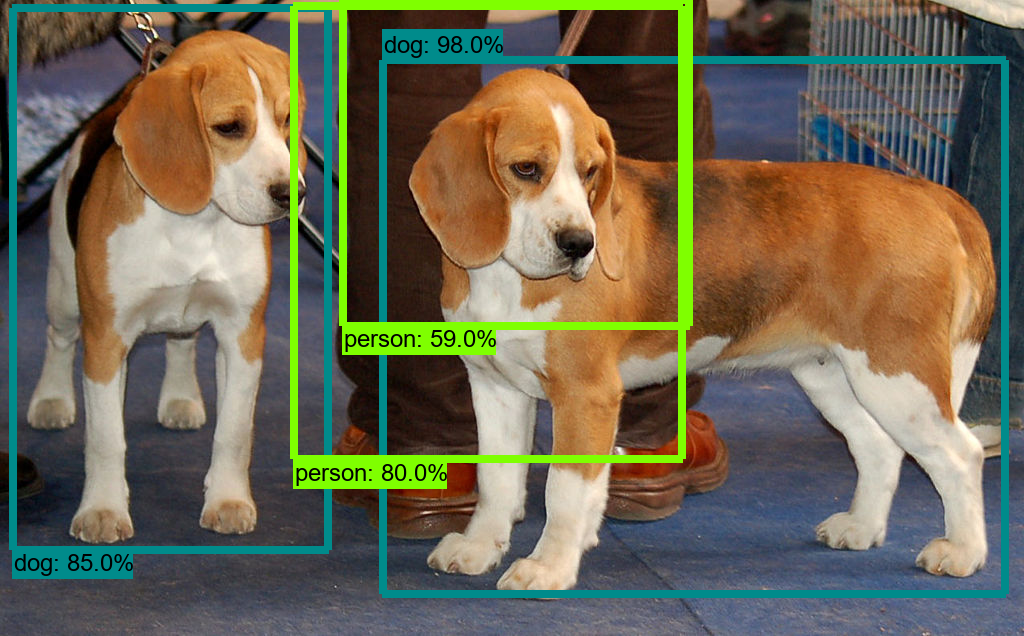

Time 1590566758.5758064
Inference time is 0.05989789962768555
{'detection_scores': array([0.9342873 , 0.8684213 , 0.8313616 , 0.79378766, 0.78208596,
       0.75753117, 0.75150084, 0.6716358 , 0.38989606, 0.34754458,
       0.33116344, 0.30388683], dtype=float32), 'detection_classes': array([38,  1, 38,  1,  1,  1, 38,  1,  1, 38, 38, 38], dtype=int64), 'detection_boxes': array([[0.08482438, 0.4380611 , 0.17121425, 0.49894646],
       [0.56564885, 0.39131486, 0.593569  , 0.40982485],
       [0.38353264, 0.3503091 , 0.40552354, 0.36863187],
       [0.5720238 , 0.05761471, 0.62415105, 0.07780795],
       [0.77107847, 0.16185525, 0.9451314 , 0.20130888],
       [0.56991774, 0.03067031, 0.62227803, 0.04641979],
       [0.27517983, 0.20607828, 0.30678192, 0.22383155],
       [0.68067646, 0.08437312, 0.8205919 , 0.11806779],
       [0.54608953, 0.25928304, 0.5592742 , 0.26780996],
       [0.3921806 , 0.42660832, 0.40826955, 0.4437657 ],
       [0.44672766, 0.7985825 , 0.47322235, 0.82408315]

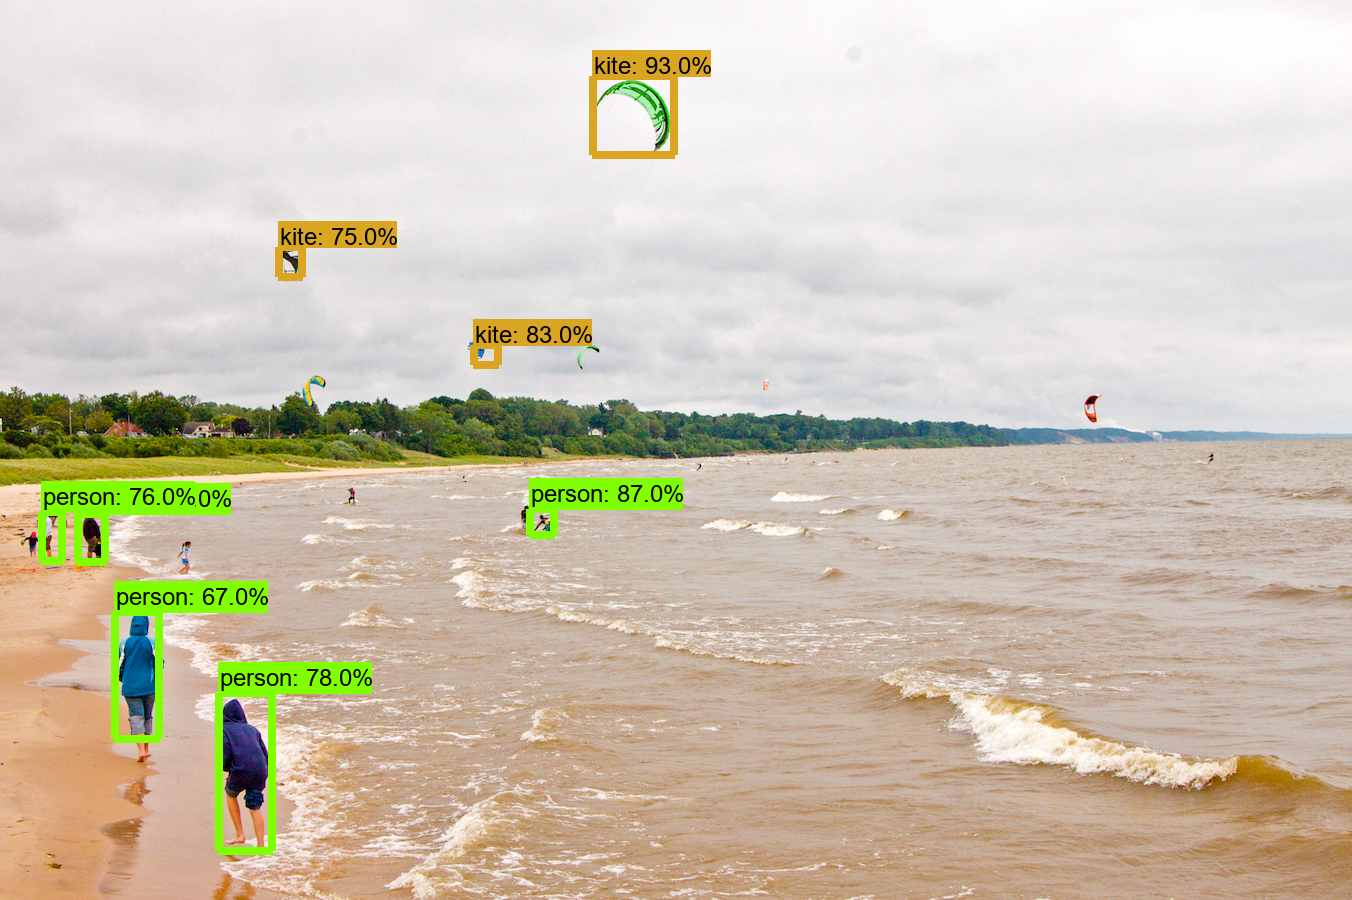

In [12]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)